In [ ]:
!nvidia-smi

Wed May 24 09:58:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q --upgrade transformers diffusers ftfy huggingface_hub
!pip install -q accelerate
!pip install -q datasets
!pip install -q open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, DPMSolverMultistepScheduler
from tqdm.auto import tqdm
import os
import cv2
from base64 import b64encode
import numpy as np 
from IPython.display import HTML
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
tokenizer = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="unet")
scheduler = DPMSolverMultistepScheduler.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="scheduler")

In [ ]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('solver_order', 2),
            ('prediction_type', 'v_prediction'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('sample_max_value', 1.0),
            ('algorithm_type', 'dpmsolver++'),
            ('solver_type', 'midpoint'),
            ('lower_order_final', True),
            ('use_karras_sigmas', False),
            ('_class_name', 'DDIMScheduler'),
            ('_diffusers_version', '0.8.0'),
            ('clip_sample', False),
            ('set_alpha_to_one', False),
            ('skip_prk_steps', True),
            ('steps_offset', 1)])

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
vae.to(device)
text_encoder.to(device)
unet.to(device)
print(f'Moved vae, text_encoder , unet to {device}')

Moved vae, text_encoder , unet to cuda


In [ ]:
vae.config.scaling_factor

0.18215

In [ ]:
# let's seperate out the functions
batch_size = 1
def get_text_embeddings(prompt):
    text_input = tokenizer(
        prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
    )

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    return text_embeddings

def get_latents(text_embeddings, height=512, width=512, num_inference_steps=50,
                guidance_scale=7.5, latents=None, seed=0,
                return_all_latents=False):
    
    generator = torch.manual_seed(seed)
    batch_size = text_embeddings.shape[0]//2

    if latents == None:
        latents = torch.randn(
            batch_size, unet.config.in_channels, height//8, width//8,
            generator=generator
        )
        print(f'Creating latents : {latents.shape}')
    latents = latents.to(device)
    print(f'Created latents : {latents.shape}')
    latents = latents * scheduler.init_noise_sigma

    #all_latents
    all_latents = [latents]
    print(f'len(all_latents) : {len(all_latents)} all_latents[0] : {all_latents[0].shape}')

    scheduler.set_timesteps(num_inference_steps)

    for t in tqdm(scheduler.timesteps):
        print(f'*************t - {t} *************')
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        print(f'latent_model_input.shape : {latent_model_input.shape}')

        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)
        print(f'latent_model_input.shape : {latent_model_input.shape}')

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t.to(dtype=torch.float32), encoder_hidden_states=text_embeddings).sample
            print(f'noise_pred.shape : {noise_pred.shape}')

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        print(f'noise_pred_uncond.shape : {noise_pred_uncond.shape}  noise_pred_text.shape : {noise_pred_text.shape}')
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        print(f'noise_pred.shape after gs: {noise_pred.shape}')

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        print(f'latents.shape : {latents.shape}')
        all_latents.append(latents)
        print(f'len(all_latents) : {len(all_latents)} all_latents[0] : {all_latents[0].shape} all_latents[-1] : {all_latents[-1].shape}')

    if not return_all_latents:
        print(f'OUT OF loop latents.shape : {latents.shape}')
        return latents
    
    all_latents = torch.cat(all_latents, dim=0)
    print(f'OUT OF loop all_latents.shape : {all_latents.shape}')

    return all_latents

def decode_latents_to_img(latents):
    latents = 1 / vae.config.scaling_factor * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images



def prompt_to_img(_prompt = "",
                  height = 512,  # default height of Stable Diffusion
                  width = 512,  # default width of Stable Diffusion
                  num_inference_steps = 50,  # Number of denoising steps
                  guidance_scale = 7.5,  # Scale for classifier-free guidance
                  seed = 0,  # Seed generator to create the inital latent noise
                  return_all_latents = False,
                  batch_size = 2,
                  latents = None
                  ):
    prompt = [_prompt]
    

    text_embeddings = get_text_embeddings(prompt)
    
    latents = get_latents(text_embeddings, 
                          height=height, 
                          width=width, 
                          num_inference_steps=num_inference_steps,
                          guidance_scale=guidance_scale, 
                          latents=latents, 
                          seed=seed,
                          return_all_latents=return_all_latents)
    all_imgs = []
    for i in tqdm(range(0, len(latents), batch_size)):
        imgs = decode_latents_to_img(latents[i:i+batch_size])
        all_imgs.extend(imgs)

    return all_imgs


In [ ]:
scheduler.init_noise_sigma

1.0

Creating latents : torch.Size([1, 4, 64, 64])
Created latents : torch.Size([1, 4, 64, 64])
len(all_latents) : 1 all_latents[0] : torch.Size([1, 4, 64, 64])


  0%|          | 0/50 [00:00<?, ?it/s]

*************t - 999 *************
latent_model_input.shape : torch.Size([2, 4, 64, 64])
latent_model_input.shape : torch.Size([2, 4, 64, 64])
noise_pred.shape : torch.Size([2, 4, 64, 64])
noise_pred_uncond.shape : torch.Size([1, 4, 64, 64])  noise_pred_text.shape : torch.Size([1, 4, 64, 64])
noise_pred.shape after gs: torch.Size([1, 4, 64, 64])
latents.shape : torch.Size([1, 4, 64, 64])
len(all_latents) : 2 all_latents[0] : torch.Size([1, 4, 64, 64]) all_latents[-1] : torch.Size([1, 4, 64, 64])
*************t - 979 *************
latent_model_input.shape : torch.Size([2, 4, 64, 64])
latent_model_input.shape : torch.Size([2, 4, 64, 64])
noise_pred.shape : torch.Size([2, 4, 64, 64])
noise_pred_uncond.shape : torch.Size([1, 4, 64, 64])  noise_pred_text.shape : torch.Size([1, 4, 64, 64])
noise_pred.shape after gs: torch.Size([1, 4, 64, 64])
latents.shape : torch.Size([1, 4, 64, 64])
len(all_latents) : 3 all_latents[0] : torch.Size([1, 4, 64, 64]) all_latents[-1] : torch.Size([1, 4, 64, 64]

  0%|          | 0/1 [00:00<?, ?it/s]

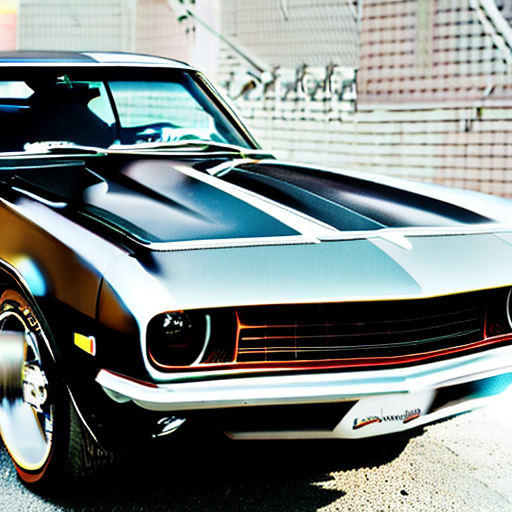

In [ ]:
prompt_to_img("chevrolet camaro 1968 photoshoot 4k black highkey", num_inference_steps = 50, return_all_latents=False, seed=42)[-1]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

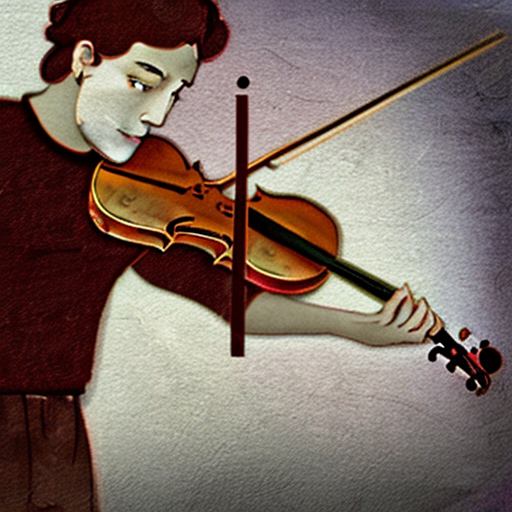

In [ ]:
prompt_to_img("Young male Italian violinist plays violin, 18th century, mystic, dramatic, storybook illustration, action, cinematic, watercolor style, ultradetailed, dark fairy tale, intricate detail, in the style of Hayao Miyazaki, Mamoru Oshii, Satoshi KonKon", num_inference_steps = 50, return_all_latents=False)[-1]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

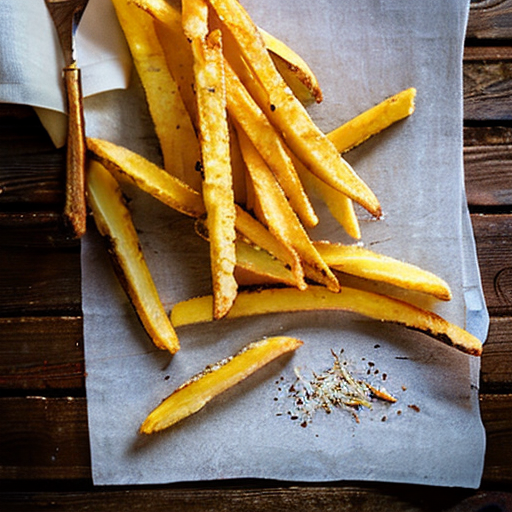

In [ ]:
prompt_to_img("French fries, The fries are spread evenly on the plate with seasoning on top, Soft natural light to avoid overexposing the fries, Placed on a rustic wooden board with a few simple props such as a knife and a napkin, The yellow of the fries contrasts with the neutral tones of the board and the props ", num_inference_steps = 50, return_all_latents=False)[-1]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

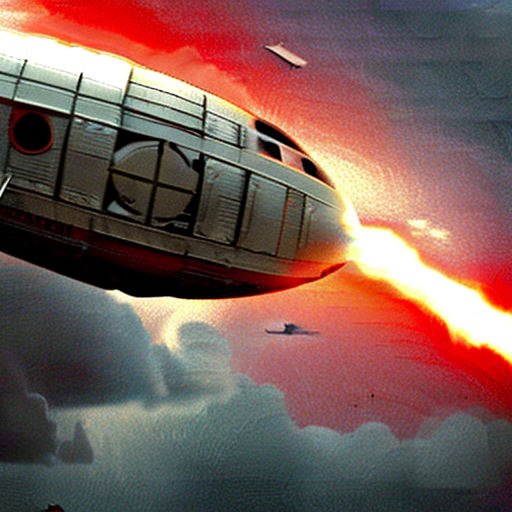

In [ ]:
prompt_to_img("Starwars airship bursting through the clouds", num_inference_steps = 50, return_all_latents=False)[-1]

In [ ]:
import os
import cv2
from base64 import b64encode
import numpy as np 
from IPython.display import HTML

In [ ]:
def imgs_to_video(imgs, video_name='video.mp4', fps=15):
  # Source: https://stackoverflow.com/questions/52414148/turn-pil-images-into-video-on-linux
  video_dims = (imgs[0].width, imgs[0].height)
  fourcc = cv2.VideoWriter_fourcc(*'DIVX')    
  video = cv2.VideoWriter(video_name, fourcc, fps, video_dims)
  for img in imgs:
    tmp_img = img.copy()
    video.write(cv2.cvtColor(np.array(tmp_img), cv2.COLOR_RGB2BGR))
  video.release()

def display_video(file_path, width=512):
  compressed_vid_path = 'comp_' + file_path
  if os.path.exists(compressed_vid_path):
    os.remove(compressed_vid_path)
  os.system(f'ffmpeg -i {file_path} -vcodec libx264 {compressed_vid_path}')

  mp4 = open(compressed_vid_path, 'rb').read()
  data_url = 'data:simul2/mp4;base64,' + b64encode(mp4).decode()
  return HTML("""
    <video width={} controls>
          <source src="{}" type="video/mp4">
    </video>
    """.format(width, data_url))

In [ ]:
video_frames = prompt_to_img(_prompt="Starwars airship bursting through the clouds",
                             num_inference_steps = 50, 
                             return_all_latents=True)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
vid_name = 'video.mp4'
imgs_to_video(video_frames, vid_name)
display_video(vid_name)

In [ ]:
video_frames = prompt_to_img(_prompt="The living room is a warm and inviting space, with a traditional European style that is both timeless and elegant. The walls are painted a crisp white, providing a bright and airy backdrop for the room. The floor is covered in a PVC coating wood grain rock gray, giving the room a classic and sophisticated look. The color palette is composed of beige, dark brown, and copper tones, creating a cozy atmosphere that is perfect for entertaining or simply relaxing. The furniture is arranged in an inviting manner, with comfortable couches and armchairs surrounding a large coffee table. The walls are adorned with tasteful artwork and framed photographs, adding to the homey feel of the room. ",
                             num_inference_steps = 50, 
                             return_all_latents=True)
vid_name = 'video.mp4'
imgs_to_video(video_frames, vid_name)
display_video(vid_name)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

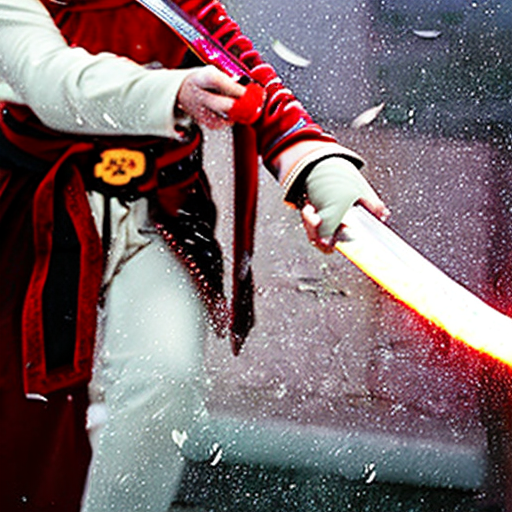

In [ ]:
prompt_to_img("A girl is charging forward with a sword in hand, portraying the martial arts of sword fighting in Chinese mythological stories. The scene is set in snowy weather with petals falling in the air, creating a tense and dynamic atmosphere. The camera focuses on a close-up shot of the girl and her sword, emphasizing the martial arts style of fighting with a sword in Chinese mythology. This shot was taken using a Red Dragon camera and 100mm lens, directed by Zhang Yimou", num_inference_steps = 50, return_all_latents=False)[-1]

![SD4](https://cdn.midjourney.com/21408058-fa54-43df-af06-59077bf1b14e/0_3.png)

In [ ]:
def perturb_latents(latents, scale = 0.1):
    noise = torch.randn_like(latents)
    new_latents = (1 - scale) * latents + scale * noise
    return (new_latents - new_latents.mean()) / new_latents.std()

In [ ]:
latents = torch.randn((1, unet.config.in_channels, 512//8, 512//8))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

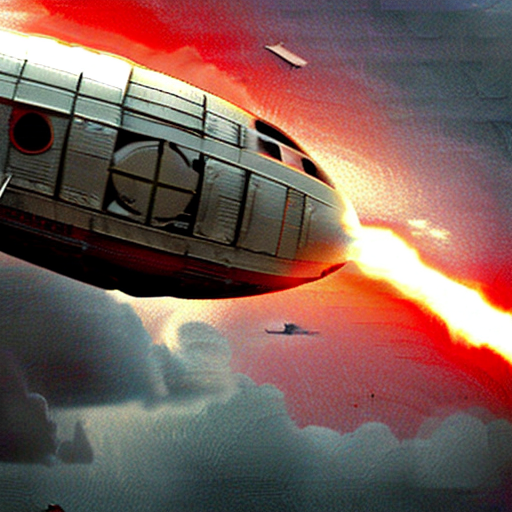

In [ ]:
prompt="Starwars airship bursting through the clouds"
prompt_to_img(prompt, num_inference_steps = 50, return_all_latents=False)[-1]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

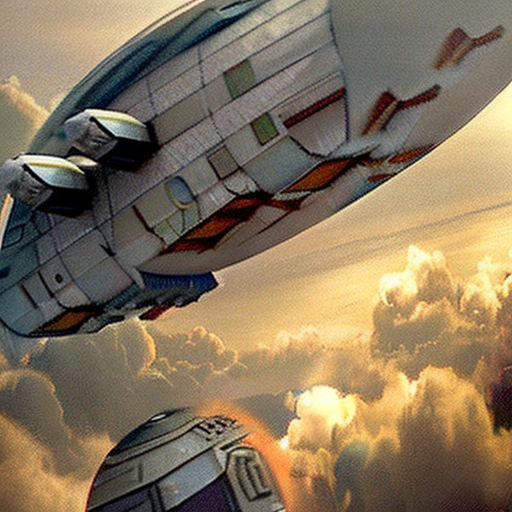

In [ ]:
new_latents = perturb_latents(latents, 0.4)
prompt_to_img(prompt, num_inference_steps=50, latents=new_latents)[-1]

In [ ]:
def decode_latents_to_img(latents):
    latents = 1 / vae.config.scaling_factor * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def encode_image_to_latents(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]

    img_arr = np.stack([np.array(img) for img in imgs], axis = 0)
    img_arr = img_arr / 255.0
    img_arr = torch.from_numpy(img_arr).float().permute(0, 3, 1, 2)
    img_arr = 2 * (img_arr - 0.5)

    latent_dists = vae.encode(img_arr.to(device)).latent_dist.sample()
    latent_samples = latent_dists
    latent_samples *= vae.config.scaling_factor

    return latent_samples
    

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

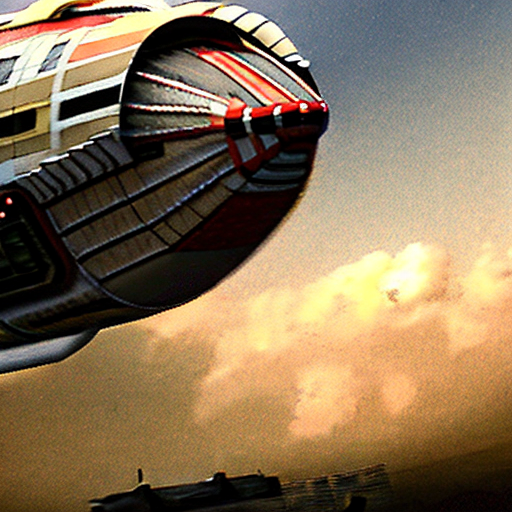

In [ ]:
# Image to Image
new_latents = perturb_latents(latents, 0.4)
img = prompt_to_img(prompt, num_inference_steps=50, latents=new_latents)[-1]
img

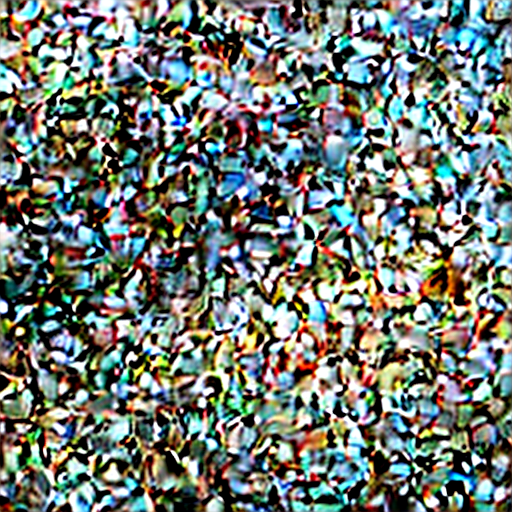

In [ ]:
img_latents = encode_image_to_latents([img])
new_latents = perturb_latents(img_latents, 0.8)
dec_img = decode_latents_to_img(new_latents.to(device))
dec_img[0]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

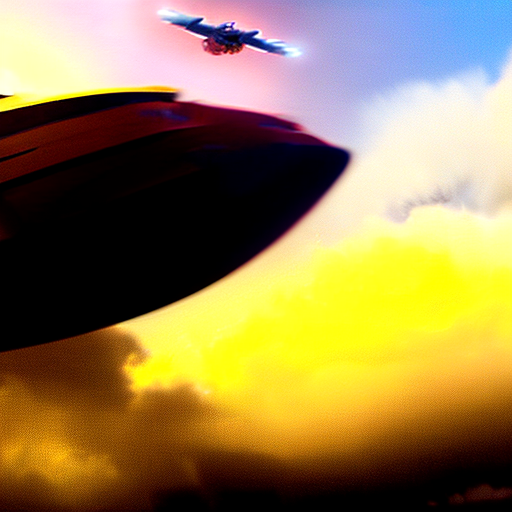

In [ ]:
prompt = "Starwars airship bursting through the clouds"
prompt_to_img(_prompt = prompt, num_inference_steps=100, latents=new_latents)[0]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

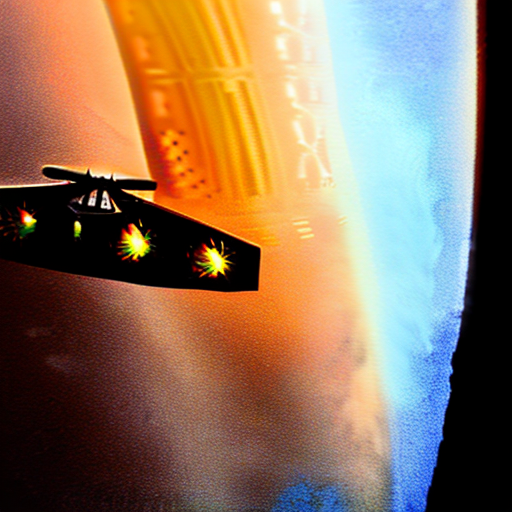

In [ ]:
img = prompt_to_img("French fries, The fries are spread evenly on the plate with seasoning on top, Soft natural light to avoid overexposing the fries, Placed on a rustic wooden board with a few simple props such as a knife and a napkin, The yellow of the fries contrasts with the neutral tones of the board and the props ", num_inference_steps = 50, return_all_latents=False)[-1]
img_latents = encode_image_to_latents([img])
new_latents = perturb_latents(img_latents, 0.9)
prompt_to_img(_prompt = prompt, num_inference_steps=50, latents=new_latents)[0]